In [110]:
from sorcha.modules.PPVisitsFootprintFilter import PPVisitsFootprint

In [111]:
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import numpy as np


In [112]:

def create_ran_pop(n=29000,ra_center=306.11749 , dec_center=-50.942, field_id=226650, radius_deg = 1.8 ):
    #random ditribution in ⭕️
    theta = np.random.uniform(0, 2*np.pi, n)
    r = radius_deg * np.sqrt(np.random.uniform(0, 1, n))

    ra = ra_center + (r * np.cos(theta))
    dec = dec_center + (r * np.sin(theta))


    obs_df = pd.DataFrame({
        "RA_deg": ra,
        "Dec_deg": dec,
        "FieldID": np.ones(n) *  field_id,
    })
    return obs_df


## This notebook uses a visits database of 2 different field ids.

field_id =  **226650** or **230070**

In [113]:
# field_id = 226650
field_id = 230070

## Make simulated observations

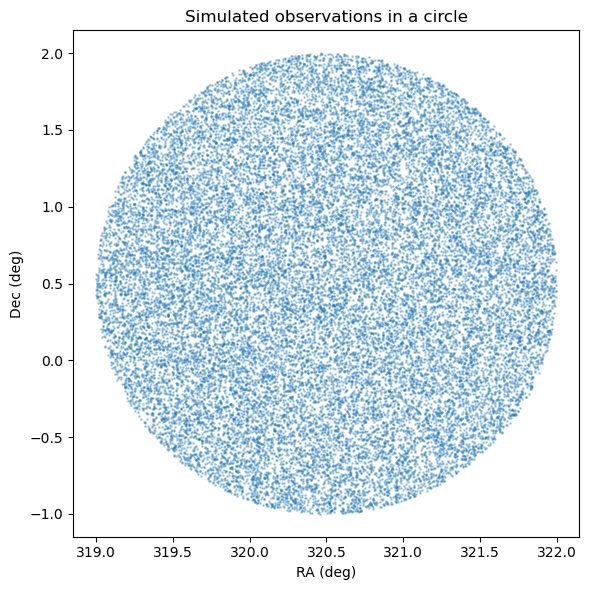

In [114]:


if field_id ==  226650:
    obs_df =  create_ran_pop()
elif field_id == 230070:
    obs_df =  create_ran_pop(dec_center=0.5,ra_center= 320.5,radius_deg=1.5,field_id=field_id)
plt.figure(figsize=(6, 6))
plt.scatter(obs_df["RA_deg"], obs_df["Dec_deg"], s=1, alpha=0.3)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Simulated observations in a circle")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

## Footprint

showing the footprint overplotted over the simulated data

DES_footprint.db is a sqlite database containing only two field ID (230070 ,226650)

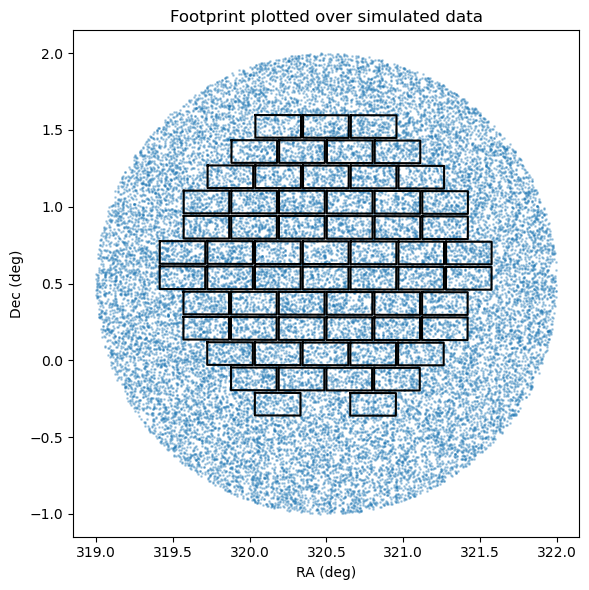

In [115]:
query = """
SELECT llcra, llcdec, lrcra, lrcdec, urcra, urcdec, ulcra, ulcdec,
       ra_centre, dec_centre, detectorID, limMag_perChip
FROM observations
WHERE VisitID = ?
"""

conn = sql.connect("DES_footprint.db")

# Make sure `field_id` is a scalar or tuple/list of one value
footprint = pd.read_sql_query(query, conn, params=(field_id,))


fig, ax = plt.subplots(figsize=(6, 6))
#make footprint 
for idx, row in footprint.iterrows():
    ra_ = [row['llcra'], row['lrcra'], row['urcra'], row['ulcra'], row['llcra']]
    dec_ = [row['llcdec'], row['lrcdec'], row['urcdec'], row['ulcdec'], row['llcdec']]
    ax.plot(ra_, dec_, '-',color = "black")  



# Labeling and appearance
ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.set_title("Footprint plotted over simulated data")

plt.scatter(obs_df["RA_deg"], obs_df["Dec_deg"], s=1, alpha=0.3)

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

## Apply visits footprint filter

Now applying the visits footprint to the simulated data

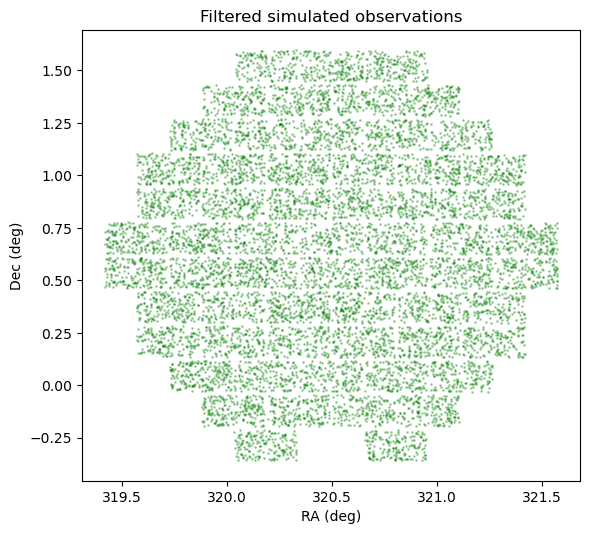

In [116]:

query = "SELECT llcra, llcdec, lrcra, lrcdec, urcra, urcdec, ulcra, ulcdec, ra_centre, dec_centre, detectorID, limMag_perChip  FROM observations WHERE visitId = ?"
visits_filename = "DES_footprint.db" 
detected_list , _, _  =PPVisitsFootprint(obs_df, query, visits_filename)
observations = obs_df.iloc[detected_list].copy()

plt.figure(figsize=(6, 6))
plt.scatter(observations["RA_deg"], observations["Dec_deg"], s=1, alpha=0.3 , color = "green")
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Filtered simulated observations")
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()


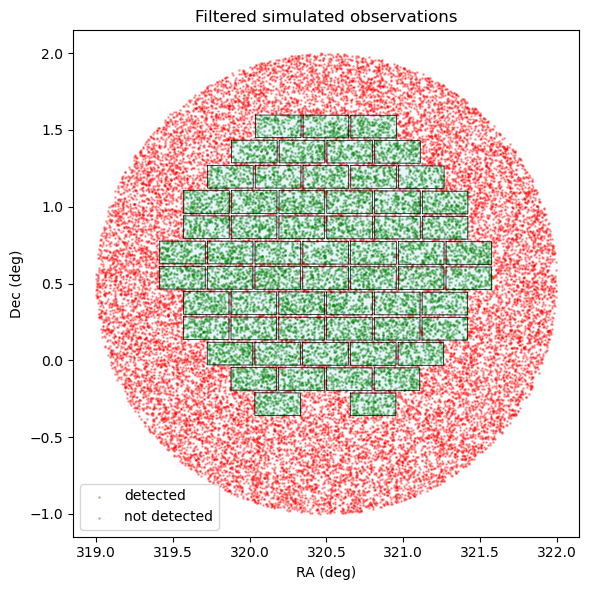

In [117]:

non_detections = obs_df[~obs_df.index.isin(observations.index)]

fig, ax = plt.subplots(figsize=(6, 6))
#plot footprint
for idx, row in footprint.iterrows():
    ra_ = [row['llcra'], row['lrcra'], row['urcra'], row['ulcra'], row['llcra']]
    dec_ = [row['llcdec'], row['lrcdec'], row['urcdec'], row['ulcdec'], row['llcdec']]
    ax.plot(ra_, dec_, '-',color = "black", linewidth=0.5)  
    ax.fill(ra_, dec_,color = "skyblue", alpha=0.2)  

# plot observations colour coded
ax.scatter(observations["RA_deg"], observations["Dec_deg"], color='green', label='detected', s=1, alpha=0.3)
ax.scatter(non_detections["RA_deg"], non_detections["Dec_deg"], color='red', label='not detected', s=1, alpha=0.3)

ax.set_xlabel("RA (deg)")
ax.set_ylabel("Dec (deg)")
ax.set_title("Filtered simulated observations")
ax.set_aspect('equal')

plt.tight_layout()
plt.legend()
plt.show()
